### Setup

In [1]:
# Imports and helper functions
from copy import deepcopy
from typing import Dict, Iterable, List, Optional

import torch
from capymoa.ann import LeNet5
from capymoa.base import BatchClassifier
from capymoa.classifier import Finetune
from capymoa.ocl.base import TrainTaskAware
from capymoa.ocl.datasets import SplitFashionMNIST
from capymoa.ocl.evaluation import OCLMetrics, ocl_train_eval_loop
from capymoa.ocl.strategy import ExperienceReplay
from capymoa.stream import Schema
from plot import plot_multiple, table
from torch import Tensor, nn

stream = SplitFashionMNIST(normalize_features=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
schema = stream.schema
results: Dict[str, OCLMetrics] = {}


def run(learner: BatchClassifier) -> OCLMetrics:
    torch.manual_seed(0)
    return ocl_train_eval_loop(
        learner,
        stream.train_loaders(64),
        stream.test_loaders(512),
        continual_evaluations=1,
        progress_bar=True,
        eval_window_size=256,
    )

# Regularisation
In this notebook, we implement L2, EWC, and SI based regularization for
continual learning.


## L2 Regularization

$$
L_{reg} = \lambda \sum_{i} (\theta_i - \theta_i^*)^2
$$

In [2]:
def l2_reg(params: Iterable[Tensor], anchor_params: Iterable[Tensor]) -> Tensor:
    l2 = 0.0
    for param, anchor_param in zip(params, anchor_params, strict=True):
        assert param.shape == anchor_param.shape
        l2 += ((param - anchor_param) ** 2).sum()
    return l2

In [3]:
class L2RegularizedCL(BatchClassifier, TrainTaskAware):
    def __init__(
        self,
        schema: Schema,
        model: nn.Module,
        lambda_: float,
        lr: float = 0.01,
        device: torch.device = device,
    ) -> None:
        super().__init__(schema)
        self.lambda_ = lambda_
        self.device = device
        self.lr = lr
        self.model = model.to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        self.criterion = nn.CrossEntropyLoss()
        self.anchor_params: Optional[List[Tensor]] = None
        self.test_task_id = 0

    def batch_train(self, x: Tensor, y: Tensor) -> None:
        self.model.train()
        self.optimizer.zero_grad()

        # Forward pass
        y_hat = self.model(x)
        classify_loss = self.criterion(y_hat, y)
        l2 = self.regularize()

        # Backward pass and step
        loss = classify_loss + self.lambda_ * l2
        loss.backward()
        self.optimizer.step()

    def regularize(self) -> Tensor:
        if self.anchor_params is not None:
            return l2_reg(self.model.parameters(), self.anchor_params)
        else:
            return torch.scalar_tensor(0.0, device=self.device)

    @torch.no_grad()
    def batch_predict_proba(self, x: torch.Tensor) -> torch.Tensor:
        return self.model.eval()(x)

    def on_train_task(self, task_id: int):
        # Adam maintains momentum, so we need to reinitialize the optimizer
        # when the task changes
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)

        # Anchoring the first task is detrimental
        if task_id == 0:
            self.anchor_params = None
        else:
            self.anchor_params = [
                param.clone().detach().to(self.device)
                for param in self.model.parameters()
            ]

Train & Eval:   0%|          | 0/1040 [00:00<?, ?it/s]

Train & Eval:   0%|          | 0/1040 [00:00<?, ?it/s]

Train & Eval:   0%|          | 0/1040 [00:00<?, ?it/s]

Train & Eval:   0%|          | 0/1040 [00:00<?, ?it/s]

Train & Eval:   0%|          | 0/1040 [00:00<?, ?it/s]

Train & Eval:   0%|          | 0/1040 [00:00<?, ?it/s]

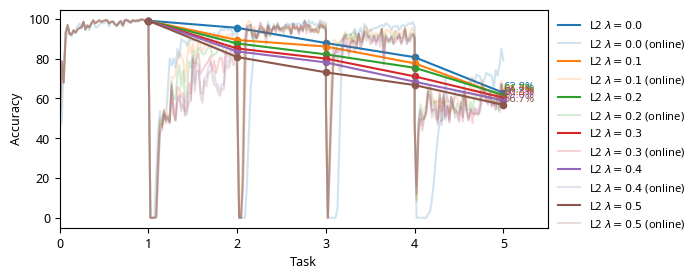

In [4]:
for lambda_ in [0, 0.1, 0.2, 0.3, 0.4, 0.5]:
    results[f"L2 $\\lambda={lambda_:.1f}$"] = run(
        ExperienceReplay(
            L2RegularizedCL(schema, LeNet5(10), lambda_=lambda_, lr=0.001), 100
        )
    )
_ = plot_multiple(results, acc_seen=True, acc_online=True)

From the figure we can conclude, that L2 regularization is:

- slightly better than no regularization.
- not very effective for continual learning.
- can have a negative impact on online accuracy if the regularization
  strength is too high.

## EWC

$$
L_{EWC} = \frac{\lambda}{2} \sum_{i} F_i (\theta_i - \theta_i^*)^2
$$
where $F_i$ is the diagonal of the Fisher information matrix. The fisher
information matrix measures how important a parameter is for the task.

---
1.  Kirkpatrick, James, Razvan Pascanu, Neil Rabinowitz, Joel Veness, Guillaume
    Desjardins, Andrei A. Rusu, Kieran Milan, et al. **“Overcoming Catastrophic Forgetting
    in Neural Networks.”** Proceedings of the National Academy of Sciences 114, no. 13
    (March 28, 2017): 3521–26. https://doi.org/10.1073/pnas.1611835114.

In [5]:
def weighted_l2_reg(
    params: Iterable[Tensor],
    anchor_params: Iterable[Tensor],
    fisher_diags: Iterable[Tensor],
) -> Tensor:
    l2 = torch.scalar_tensor(0.0)
    for param, anchor_param, fisher_diag in zip(
        params, anchor_params, fisher_diags, strict=True
    ):
        assert param.shape == anchor_param.shape
        l2 += (fisher_diag * (param - anchor_param) ** 2).sum()
    return l2 / 2

In [6]:
from capymoa.stream import Schema
from torch import Tensor
from torch.nn.modules import Module


class EWC(L2RegularizedCL):
    def __init__(
        self,
        schema: Schema,
        model: Module,
        lambda_: float,
        fim_buffer: int = 1000,
        lr: float = 0.01,
        device: torch.device = device,
    ) -> None:
        super().__init__(schema, model, lambda_, lr, device)
        self._buffer_x: Tensor = torch.zeros(
            (fim_buffer, schema.get_num_attributes()), device=device
        )
        self._buffer_y: Tensor = torch.zeros((fim_buffer,), device=device).long()
        self._buffer_index = 0
        self._buffer_size = fim_buffer
        self.fim_diags: Optional[List[Tensor]] = None

    def batch_train(self, x: Tensor, y: Tensor):
        super().batch_train(x, y)
        # Use the buffer as a ring buffer
        for i in range(x.shape[0]):
            self._buffer_x[self._buffer_index] = x[i]
            self._buffer_y[self._buffer_index] = y[i]
            self._buffer_index += 1
            if self._buffer_index >= self._buffer_size:
                self._buffer_index = 0

    @torch.enable_grad()
    def compute_fisher(self) -> List[Tensor]:
        self.model.eval()
        fisher_diags = [torch.zeros_like(param) for param in self.model.parameters()]

        for x, y in zip(self._buffer_x, self._buffer_y):
            x = x.unsqueeze(0)
            y = y.unsqueeze(0)
            self.model.zero_grad()
            y_hat = self.model(x)
            loss = self.criterion(y_hat, y)
            loss.backward()

            for fisher_diag, param in zip(
                fisher_diags, self.model.parameters(), strict=True
            ):
                if param.grad is None:
                    continue
                fisher_diag.add_(param.grad.detach() ** 2)

        for fisher_diag in fisher_diags:
            fisher_diag.div_(self._buffer_size)
        return fisher_diags

    def on_train_task(self, task_id: int):
        # Adam maintains momentum, so we need to reinitialize the optimizer
        # when the task changes
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)

        if task_id == 0:
            return
        print(f"Computing Fisher information matrix for task {task_id}")
        fim_diags = self.compute_fisher()
        if self.fim_diags is None:
            self.fim_diags = fim_diags
        else:
            for i in range(len(self.fim_diags)):
                self.fim_diags[i] += fim_diags[i]

    def regularize(self) -> Tensor:
        if self.anchor_params is not None and self.fim_diags is not None:
            return weighted_l2_reg(
                self.model.parameters(), self.anchor_params, self.fim_diags
            )
        else:
            return torch.scalar_tensor(0.0)

Train & Eval:   0%|          | 0/1040 [00:00<?, ?it/s]

Computing Fisher information matrix for task 1


Computing Fisher information matrix for task 2


Computing Fisher information matrix for task 3


Computing Fisher information matrix for task 4


Train & Eval:   0%|          | 0/1040 [00:00<?, ?it/s]

Computing Fisher information matrix for task 1


Computing Fisher information matrix for task 2


Computing Fisher information matrix for task 3


Computing Fisher information matrix for task 4


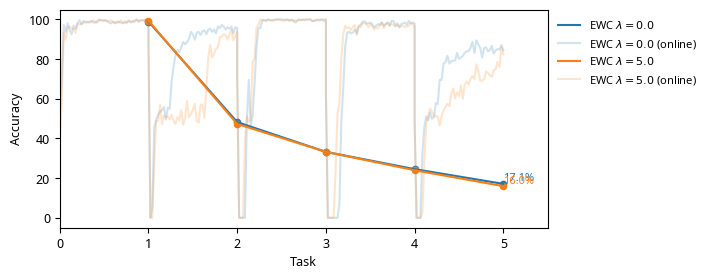

In [7]:
torch.manual_seed(0)
results.clear()
for lambda_ in [
    0,
    # 0.1,
    5,
]:
    results[f"EWC $\\lambda={lambda_:.1f}$"] = run(
        EWC(schema, LeNet5(10), lambda_=lambda_, lr=0.01)
    )
_ = plot_multiple(results, acc_seen=True, acc_online=True)

## Learning without Forgetting (LWF)

### Knowledge Distillation
Knowledge distillation loss function from Hinton et al. (2015) [1][3].

A type of response-based distillation that forces the student to mimic the output class probabilities of the teacher model. The loss is calculated as:

$$
L_{KD} = t^2 \times KL\left(
    \text{softmax}(\mathbf{a}/t),
    \text{softmax}(\mathbf{b}/t)
\right)
$$

where:

- $t$ is the temperature for the softmax function.
- $\mathbf{a}$ is the output (logits) from the teacher model.
- $\mathbf{b}$ is the output (logits) from the student model.
- $\mathbf{x}$ is the input to the model.

The original paper uses the cross-entropy loss between the soft targets and soft predictions. Cross-entropy loss can be defined as the Kullback-Leibler (KL) divergence plus the entropy of the target distribution [2]. The entropy of the target distribution is irrelevant to optimization since it is a constant. It is removed in this implementation, which is nice since the loss will equal zero when the student model matches the teacher model.

---
[1] Geoffrey Hinton, Oriol Vinyals, Jeff Dean (2015) Distilling the Knowledge in a Neural Network  
[2] https://en.wikipedia.org/wiki/Cross-entropy  
[3] https://intellabs.github.io/distiller/knowledge_distillation.html


In [8]:
from torch.nn.functional import kl_div, log_softmax


def hinton_kdistill_loss(
    teacher_logits: Tensor, student_logits: Tensor, temperature: float
) -> Tensor:
    return (
        kl_div(
            log_softmax(student_logits / temperature, dim=1),  # Soft predictions
            log_softmax(teacher_logits / temperature, dim=1),  # Soft targets
            log_target=True,
            reduction="batchmean",  # Mathematically correct unlike the default
        )
        * temperature**2
    )

In [9]:
class LWF(BatchClassifier, TrainTaskAware):
    def __init__(
        self,
        schema: Schema,
        model: nn.Module,
        lambda_: float,
        lr: float = 0.001,
        device: torch.device = device,
    ) -> None:
        super().__init__(schema)
        self.lambda_ = lambda_
        self.device = device
        self.lr = lr
        self.model = model.to(self.device)
        self.teacher: Optional[nn.Module] = None
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        self.criterion = nn.CrossEntropyLoss()

    def batch_train(self, x: Tensor, y: Tensor):
        self.model.train()
        self.optimizer.zero_grad()
        y_hat = self.model(x)

        ce_loss = self.criterion(y_hat, y)
        kd_loss = self.kd_loss(x, y_hat)
        loss = ce_loss + self.lambda_ * kd_loss
        loss.backward()
        self.optimizer.step()

    def kd_loss(self, x: Tensor, student_logits: Tensor) -> Tensor:
        if self.teacher is None:
            return torch.scalar_tensor(0.0, device=self.device)
        with torch.no_grad():
            teacher_logits = self.teacher(x)
        return hinton_kdistill_loss(
            teacher_logits=teacher_logits,
            student_logits=student_logits,
            temperature=2.0,
        )

    def on_train_task(self, task_id: int):
        if task_id == 0:
            return
        print(f"Updating Teacher: {task_id}")
        self.teacher = deepcopy(self.model)
        self.teacher.eval()

    @torch.no_grad()
    def batch_predict_proba(self, x: Tensor) -> Tensor:
        return self.model.eval()(x)

Train & Eval:   0%|          | 0/1040 [00:00<?, ?it/s]

Updating Teacher: 1


Updating Teacher: 2


Updating Teacher: 3


Updating Teacher: 4


Train & Eval:   0%|          | 0/1040 [00:00<?, ?it/s]

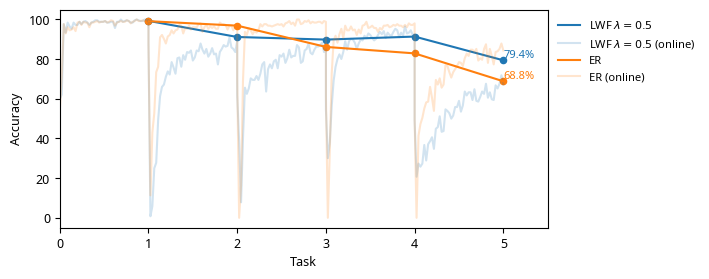

In [10]:
results.clear()
results["LWF $\\lambda=0.5$"] = run(
    ExperienceReplay(LWF(schema, LeNet5(10), lambda_=0.5), 200, repeat=2)
)
results["ER"] = run(
    ExperienceReplay(Finetune(schema, LeNet5(10), device=device), 200, repeat=2)
)
_ = plot_multiple(results, acc_seen=True, acc_online=True)

In [11]:
table(results)

,name,Final Accuracy,Average Accuracy,Online Accuracy,CPU Time (s)
0,LWF $\lambda=0.5$,79.4,90.2,76.9,121.6
1,ER,68.8,86.8,88.4,121.1
